## Target
The goal of this competition is to predict rainfall for each day of the year.

ML tools: 
  tidymodels related worksflows & glm, lightgbm, ranger engine.
Evaluatioin metric:
  roc_auc, percent of rain probability.
  sample_submission.csv : 0.5. it is value is 0. I tried change it to 1, the score is 0.5 as well.
  kaggle best score is 0.87 in the begining.
  
Notice:
- from small data, data usage is as important as feature engineering. cv with repeate could slightly reduce the variance(std_err). as side effect, the metric might be improve a bit as well.
- in last stage, consider change cv =10, repeate = 5. it is computation expensive task. only do at final stage.

## librar y & load_data

### library


In [1]:
library(tidyverse)
library(tidymodels)
library(finetune)
library(future)
library(purrr)
library(furrr)
library(textrecipes)
library(themis)


library(bonsai)
library(lightgbm)
library(xgboost)
library(ranger)

library(readr)
library(janitor)
library(lubridate)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.0     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### loading data



In [2]:
data_path <- '../input/playground-series-s5e3/'
train<- 
  readr::read_csv(file.path(data_path, 'train.csv'),
                  show_col_types = FALSE)|>
  mutate(rainfall=as.factor(rainfall))
test <- 
  readr::read_csv(file.path(data_path, 'test.csv'),
                  show_col_types = FALSE)
submission <-  readr::read_csv(file.path(data_path, 'sample_submission.csv'),show_col_types = FALSE)


### check if train & test is same distribution



In [3]:
get_df_var<-function(df){
  df|>
    select(-any_of(c('id','rainfall')))|>
    summarize_all(var)|>
    pivot_longer(cols=everything(),
                 names_to='feature',
                 values_to='variance')

}
list(train=train, test=test)|>
  map_dfr(\(x) get_df_var(x), .id = "dataset") |>
  pivot_wider(names_from=dataset, values_from = variance)|>
  mutate(pct_change=(train-test)/train)#|>arrange(desc(abs(diff)))


feature,train,test,pct_change
<chr>,<dbl>,<dbl>,<dbl>
day,11067.79587,11117.22908,-0.004466400
pressure,31.98316,30.31461,0.052169563
maxtemp,31.97145,32.17750,-0.006444710
temparature,27.27357,27.85832,-0.021440388
mintemp,25.59470,26.73659,-0.044614389
dewpoint,27.96724,29.06471,-0.039241076
humidity,60.85020,61.13229,-0.004635833
cloud,324.95461,321.63271,0.010222658
sunshine,13.15025,13.24430,-0.007152237


### Finding of different distribution
there is no big change found 

## EDA

### time series EDA


## coding

### 1. Data Loading and Initial Exploration ----

### 2. Feature Engineering ----

-   leave it in the preprocessing recipe

### 3. Data Splitting ----

#### augment_df

#### split/cv


In [ ]:
set.seed(1234)

df_split <- initial_split(train, prop = 0.8, strata = rainfall)
train_set <- training(df_split)
test_set <- testing(df_split)
cv_folds <- vfold_cv(train_set,
                     v = 10,
                     repeats = 5,
                     strata = rainfall)


### 4. Preprocessing Recipe ----

#### 4.0 v0 base_line - 


In [5]:
rcp_bs_v0 <-
  recipe(rainfall ~ ., data = train_set) |>
  update_role(id, new_role='ID')|>
  #step_rm(date,year_offset)|>
  step_impute_median(all_numeric_predictors())|> 
  step_YeoJohnson(all_numeric_predictors()) |>
  # process the logical feature to factor feature
  step_bin2factor(all_logical_predictors())|>
  # proceeding the convert the character feature to factorical feature
  step_novel(all_nominal_predictors())|>
  step_unknown(all_nominal_predictors()) |>
  step_other(all_nominal_predictors())|>
  step_dummy(all_nominal_predictors(),one_hot = TRUE) |>
  step_nzv(all_predictors())|>
  #step_corr(all_numeric_predictors())|>
  step_normalize(all_numeric_predictors())|> # Scale numeric predictors
  #step_smote(rainfall,over_ratio = 1,skip = TRUE)|>
  check_missing(all_predictors())


#### 4.11 v11_box_cox



#### 4.12 v3 


In [6]:
rcp_v12 <-
  recipe(rainfall ~ ., data = train_set) |>
  update_role(id, new_role='ID')|>
  step_impute_median(all_numeric_predictors())|> 
  step_mutate(
    cloud = cloud /100,
    sunshine = sunshine/12,
    dewpoint_averge = dewpoint -temparature,
    humidity_sig = 1 / (1 + exp(-0.2*(humidity - 80)))
    )|>
  step_rm(id,day,dewpoint,winddirection,maxtemp,mintemp)|>
  step_normalize(all_numeric_predictors())|>
  step_zv(all_predictors())|>
  step_corr(all_predictors())|>
  check_missing(all_predictors())

#### 4.13 v5 


In [7]:
rcp_v13 <-
   recipe(rainfall ~ ., data = train_set) |>
  update_role(id, new_role='ID')|>
  step_mutate(
    cloud = cloud /100,
    sunshine = sunshine/12,
    dewpoint_averge = dewpoint -temparature,
    temp_range = maxtemp-mintemp,
    humidity_sig = 1 / (1 + exp(-0.2*(humidity - 80)))
    )|>
  step_bs(sunshine)|>
  step_lag(pressure,temparature,dewpoint_averge,temp_range, windspeed)|>
  step_impute_roll(all_numeric_predictors()) |>
  step_mutate( week= round(day/52)) |>
  step_hyperbolic(winddirection,windspeed)|>
  step_rm(id,day,dewpoint,winddirection,maxtemp,mintemp)|>
  step_dummy(all_nominal_predictors(),one_hot = TRUE)|>
  step_corr(all_numeric_predictors())|>
  step_zv(all_predictors())|>
  check_missing(all_predictors())


    
#### 4.1 v1 base_line - bad


In [8]:
rcp_bs_v1 <-
  recipe(rainfall ~ ., data = train_set) |>
  update_role(id, new_role='ID')|>
  #step_date(date, features=c('month','week'))|>
  step_impute_median(all_numeric_predictors())|> 
   step_mutate(
   temp_range= maxtemp - mintemp,
   heat_index= temparature+ 0.5 * (temparature- 10) * (humidity / 100),
   dew_dep= temparature - dewpoint,
   #cloud_sun_ratio = cloud / sunshine + 1,    
   pressure_change = c(NA, diff(pressure)),
   air_density = 1.225 , 
   wind_power = 0.5 * air_density * windspeed**3,
   wind_direction_cat = cut(winddirection, 
                            breaks=c(0, 90, 180, 270, 360), 
                            labels=c("North", "East", "South", "West"), 
                            include.lowest=TRUE),
   cloud_humidity = cloud + humidity,
   cloud_humidity_sunshine = cloud + humidity + sunshine,
   cloud_x_sunshine = cloud * sunshine,
   humidity_x_sunshine = humidity * sunshine)|>
  #step_rm(date,year_offset)|>
  step_impute_median(all_numeric_predictors())|> 
  step_YeoJohnson(all_numeric_predictors()) |>
  # process the logical feature to factor feature
  step_bin2factor(all_logical_predictors())|>
  # proceeding the convert the character feature to factorical feature
  step_novel(all_nominal_predictors())|>
  step_unknown(all_nominal_predictors()) |>
  step_other(all_nominal_predictors())|>
  step_dummy(all_nominal_predictors(),one_hot = TRUE) |>
  step_nzv(all_predictors())|>
  step_corr(all_numeric_predictors())|>
  step_normalize(all_numeric_predictors())|> # Scale numeric predictors

  check_missing(all_predictors())



#### 4.2 v2 base_line - 


#### 4.10 all recipes



In [9]:
set.seed(1234)
library(future)
library(furrr)
selected_rcps <- list(#bs=rcp_bs_v0,
                    #v11= rcp_v11_boxcox,
                    #v12=rcp_v12,
                    v13=rcp_v13
                      #bs_wd_smote=rcp_bs_v0_wd_smote
                      #bs_v1=rcp_bs_v1,#, # is significanttly change the data , and performance is descress . give it up.
                      #bs_v2=rcp_bs_v2
                      )


### 5. Model Specification ----



In [10]:
glm_eng <- 
  logistic_reg(penalty = 0.01623777,
               mixture = 0.05) |>  # Example penalty and mixture values
  set_engine("glmnet") |>
  set_mode("classification")    # Specify classification

lgbm_eng<-
   parsnip::boost_tree(
      trees = 500, # Number of trees
      learn_rate = 0.01,
      tree_depth =5,
      loss_reduction = 0.001,
      stop_iter = 50,
      sample_size = 0.9, # Added sample_size
      min_n = 100
   ) |>
   set_mode("classification")|>
   set_engine("lightgbm",
              num_leaves = 20,
              counts = FALSE,
              num_threads=12,
              metric = "auc",              # 优化目标
              verbose=1) 

rf_eng<- rand_forest( trees = 700, 
                      min_n=100) |>
  set_engine("ranger",num.threads=4)|>
  set_mode("classification") 

xgb_eng<- parsnip::boost_tree( trees = 500, 
                      learn_rate = 0.01,
                      loss_reduction = 0.001,
                      sample_size = 0.8, # Added sample_size
                      min_n=70) |>
  set_engine("xgboost",num.threads=8)|>
  set_mode("classification")

c50_eng <- boost_tree() |>
  set_mode('classification')|>
  set_engine('C5.0')

earth_eng <-  # good model base score 0.8718
  mars() |> 
  set_mode("classification") |>
  set_engine("earth") 

svm_eng <- 
  svm_rbf(
    cost = 0.001, 
    rbf_sigma = 0.01
    )  |>
  set_mode("classification") 

kknn_eng <- 
  nearest_neighbor(neighbors = 5 ) |>
  set_mode("classification")|> 
  set_engine("kknn") 

selected_eng <- list(glm=glm_eng,
                     rf=rf_eng,
                     lgbm=lgbm_eng,
                     xgb=xgb_eng,
                     #c50=c50_eng,
                     earth= earth_eng,
                     #kknn=kknn_eng,
                     svm=svm_eng)


### 6. Workflow ----
#### set metrics


In [11]:
rocauc_metrics <- metric_set(roc_auc) # main goal is roc_auc, accuracy is just for reference



#### simple wflow



In [12]:
set.seed(1234)

simple_wf_fit <- 
  workflow() |>
  add_recipe(rcp_v13) |>
  add_model(lgbm_eng)|>
  # fit(train_set)
  fit_resamples(cv_folds,
  #  last_fit(df_split,
          control = control_resamples(verbose=TRUE),
           metrics=rocauc_metrics)
#plan(sequential)
 simple_wf_fit |> collect_metrics()
#   extract_fit_engine()|>
#   plot()


i Fold1: preprocessor 1/1

✓ Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/1

✓ Fold1: preprocessor 1/1, model 1/1

i Fold1: preprocessor 1/1, model 1/1 (extracts)

i Fold1: preprocessor 1/1, model 1/1 (predictions)

! Fold1: preprocessor 1/1, model 1/1 (predictions): some 'x' values beyond boundary knots may cause ill-conditioned bases

i Fold2: preprocessor 1/1

✓ Fold2: preprocessor 1/1

i Fold2: preprocessor 1/1, model 1/1

✓ Fold2: preprocessor 1/1, model 1/1

i Fold2: preprocessor 1/1, model 1/1 (extracts)

i Fold2: preprocessor 1/1, model 1/1 (predictions)

i Fold3: preprocessor 1/1

✓ Fold3: preprocessor 1/1

i Fold3: preprocessor 1/1, model 1/1

✓ Fold3: preprocessor 1/1, model 1/1

i Fold3: preprocessor 1/1, model 1/1 (extracts)

i Fold3: preprocessor 1/1, model 1/1 (predictions)



.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
roc_auc,binary,0.9033512,3,0.01761373,Preprocessor1_Model1


#### simple workflowset



In [13]:
set.seed(1234)
library(future)
plan(multisession,workers = 16)
ctrl <- control_resamples(save_pred = TRUE, save_workflow = TRUE,verbose=TRUE)
wfs_result <-
  workflow_set(preproc = selected_rcps,
               models = selected_eng ) |>
  workflow_map(fn='fit_resamples',
               resamples =cv_folds,
               metrics =rocauc_metrics,
               control = ctrl
               )
wfs_result|> 
  collect_metrics()  |>
  filter(.metric=='roc_auc')|>
  select(wflow_id, model, .metric,mean, n, std_err
         )
  
plan(sequential)


i Fold1: preprocessor 1/1

✓ Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/1

✓ Fold1: preprocessor 1/1, model 1/1

i Fold1: preprocessor 1/1, model 1/1 (extracts)

i Fold1: preprocessor 1/1, model 1/1 (predictions)

! Fold1: preprocessor 1/1, model 1/1 (predictions): some 'x' values beyond boundary knots may cause ill-conditioned bases

i Fold2: preprocessor 1/1

✓ Fold2: preprocessor 1/1

i Fold2: preprocessor 1/1, model 1/1

✓ Fold2: preprocessor 1/1, model 1/1

i Fold2: preprocessor 1/1, model 1/1 (extracts)

i Fold2: preprocessor 1/1, model 1/1 (predictions)

i Fold3: preprocessor 1/1

✓ Fold3: preprocessor 1/1

i Fold3: preprocessor 1/1, model 1/1

✓ Fold3: preprocessor 1/1, model 1/1

i Fold3: preprocessor 1/1, model 1/1 (extracts)

i Fold3: preprocessor 1/1, model 1/1 (predictions)

i Fold1: preprocessor 1/1

✓ Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/1

✓ Fold1: preprocessor 1/1, model 1/1

i Fold1: preprocessor 1/1, model 1/1 (extracts)

i Fol

wflow_id,model,.metric,mean,n,std_err
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
v13_glm,logistic_reg,roc_auc,0.9088331,3,0.01447034
v13_rf,rand_forest,roc_auc,0.9033670,3,0.02124117
v13_lgbm,boost_tree,roc_auc,0.9038563,3,0.01708257
v13_xgb,boost_tree,roc_auc,0.8852483,3,0.02517506
v13_earth,mars,roc_auc,0.8856850,3,0.01244124
v13_svm,svm_rbf,roc_auc,0.9004577,3,0.01794545


### 7 stacking

Warning message:
"The inputted `candidates` argument `v13_glm` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()` (`?tune::collect_notes()`) if so."
Warning message:
"The inputted `candidates` argument `v13_rf` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()` (`?tune::collect_notes()`) if so."
Warning message:
"The inputted `candidates` argument `v13_lgbm` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()` (`?tune::collect_notes()`) if so."
Warning message:
"The inputted `candidates` argument `v13_xgb` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()` (`?tune::collect_notes()`) if so."
Warning message:
"The inputted `candidates` argument `v13_earth` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()

[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 16
[LightGBM] [Warning] Unknown parameter: 500,0.01,5,1,100,0.001,0.9,50,20,auc,79953,TRUE,1,1,binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]:  validation's auc:0.892512 
Will train until there is no improvement in 50 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]:  validation's auc:0.899492 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]:  validation's auc:0.900301 
[LightGBM] [Warning] No further sp

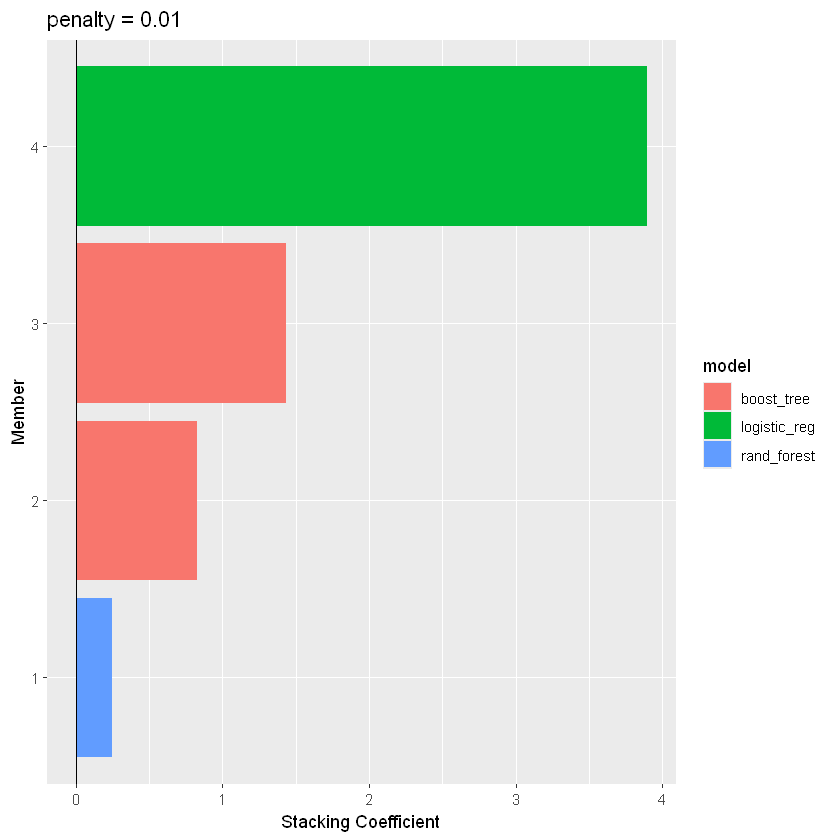

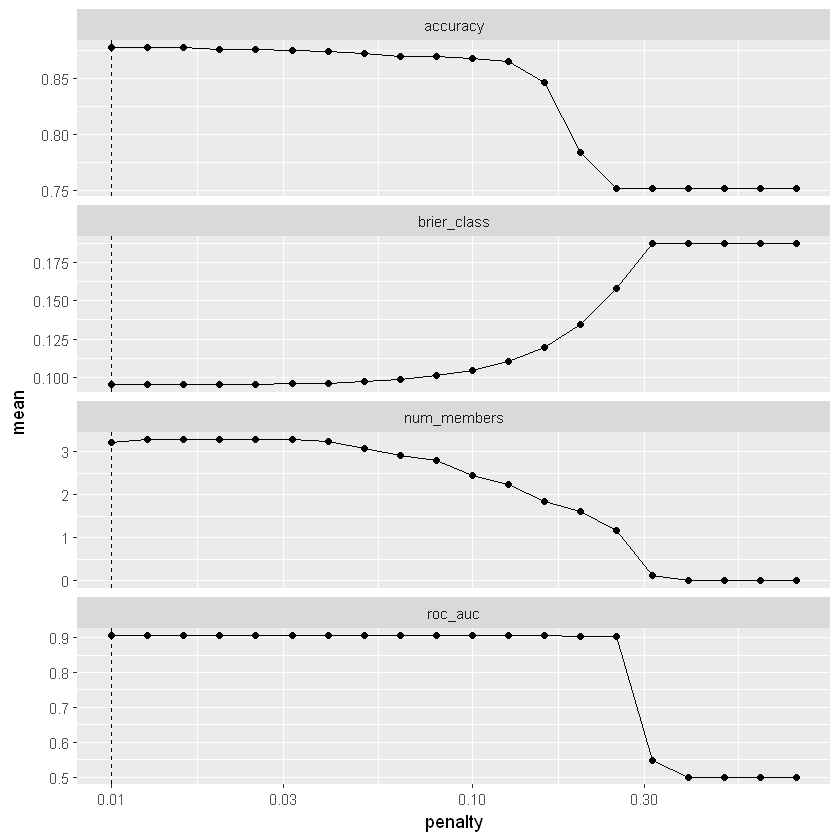

In [14]:
set.seed(1234)
library(future)
#plan(multisession,workers = 4) # comments it ,as stack not work well with lightgbm in parallell mode. it may related to environment.
combined_fit <-
  stacks::stacks()|>
  stacks::add_candidates(wfs_result)|>
  stacks::blend_predictions(penalty = 10^seq(-2, -0.1, length = 20))|>
  stacks::fit_members()

combined_fit|>
  autoplot(type = "weights")

autoplot(combined_fit)
#plan(sequential)

### 7. Tuning Grid ----
#### tune lgbm



#### tune glmnet


### 8. Cross-Validation ----



### 9. Tuning and Evaluation ----



### 10. Evaluate on Test Set ----



In [15]:
combined_test_result <- 
  test_set %>%
  bind_cols(predict(combined_fit, 
                    new_data=test_set,type='prob'))
combined_test_result|>rocauc_metrics(rainfall, .pred_1,event_level = 'second')


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8992705


### 11. Prepare Submission ----



In [16]:
set.seed(1234)
library(future)
plan(multisession,workers = 4)
final_model <- combined_fit
final_predictions <- final_model |>
   predict(new_data = test,
           type='prob') 
plan(sequential)
 # Save submission file
 submission |>
   mutate(rainfall=final_predictions$.pred_1)|>
   readr::write_csv("submission.csv")